In [ ]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [ ]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_train = datasets.MNIST(root = "./data", train = True, download = True, transform = transforms)
mnist_test = datasets.MNIST(root = "./data", train = False, download = True, transform = transforms)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
batch_size = 64
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = False)

In [ ]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
# Architecture for creating MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28*28, 30)
        self.lin2 = nn.Linear(30, 20)
        self.lin3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [ ]:
model = MLP()
model = model.to(device)

In [ ]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([30, 784])
lin1.bias torch.Size([30])
lin2.weight torch.Size([20, 30])
lin2.bias torch.Size([20])
lin3.weight torch.Size([10, 20])
lin3.bias torch.Size([10])


In [ ]:
# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 100
print_every = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(mnist_train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % print_every == 0:
        average_loss = running_loss / len(mnist_train_loader)
        print(f"Epoch: {epoch} | Loss: {average_loss}")

Epoch: 0 | Loss: 0.4623972014831836
Epoch: 1 | Loss: 0.3155911490678597
Epoch: 2 | Loss: 0.3015969409378988
Epoch: 3 | Loss: 0.29182744560354174
Epoch: 4 | Loss: 0.2797980871258069
Epoch: 5 | Loss: 0.27570817222409666
Epoch: 6 | Loss: 0.2738770864316141
Epoch: 7 | Loss: 0.2703147907771154
Epoch: 8 | Loss: 0.26976374477179826
Epoch: 9 | Loss: 0.27118190639674156
Epoch: 10 | Loss: 0.26632343899450706
Epoch: 11 | Loss: 0.25858460579401077
Epoch: 12 | Loss: 0.25908921027718895
Epoch: 13 | Loss: 0.25994917479103435
Epoch: 14 | Loss: 0.2554103481307276
Epoch: 15 | Loss: 0.2580425610849217
Epoch: 16 | Loss: 0.2513538996504346
Epoch: 17 | Loss: 0.2553845516193523
Epoch: 18 | Loss: 0.2465712667059606
Epoch: 19 | Loss: 0.2473563400349383
Epoch: 20 | Loss: 0.2490452427540157
Epoch: 21 | Loss: 0.2397025572374336
Epoch: 22 | Loss: 0.2433341261861262
Epoch: 23 | Loss: 0.24223705236790086
Epoch: 24 | Loss: 0.2437674410637222
Epoch: 25 | Loss: 0.23856009880124507
Epoch: 26 | Loss: 0.2416790608775371
E

In [ ]:
def predict(model, data_loader):
    predictions = []
    ground_truth = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.view(inputs.size(0), -1))
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            ground_truth.extend(labels.tolist())
    return predictions, ground_truth

In [ ]:
def extract_features_labels(loader):
    features = []
    labels = []
    for images, targets in loader:
        features.append(images.view(images.size(0), -1).numpy())
        labels.append(targets.numpy())
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

train_features, train_labels = extract_features_labels(mnist_train_loader)
test_features, test_labels = extract_features_labels(mnist_test_loader)

train_features.shape, test_features.shape

((60000, 784), (10000, 784))

In [ ]:
#MLP Predictions
test_predictions, test_ground_truth = predict(model, mnist_test_loader)

model_accuracy = accuracy_score(test_ground_truth, test_predictions)
model_f1 = f1_score(test_ground_truth, test_predictions, average = "weighted")
print('Accuracy:', model_accuracy)
print('F1 Score:', model_f1)

Accuracy: 0.9363
F1 Score: 0.9361715302625998


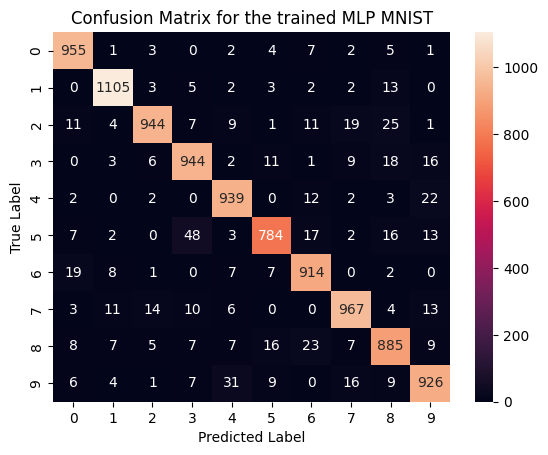

In [ ]:
# MLP Confusion Matrix
cm = confusion_matrix(test_ground_truth, test_predictions)
sns.heatmap(cm, annot = True, fmt = "d")
plt.title("Confusion Matrix for the trained MLP MNIST")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Logistic Regression Model Predictions
lr_model = LogisticRegression(max_iter = 1000, random_state = 35)
lr_model.fit(train_features, train_labels)

lr_predictions = lr_model.predict(test_features)
lr_accuracy = accuracy_score(test_labels, lr_predictions)
lr_f1 = f1_score(test_labels, lr_predictions, average = "weighted")

In [ ]:
print('Accuracy:', lr_accuracy)
print('F1 score:', lr_f1)

Accuracy: 0.9253
F1 score: 0.925154481472786


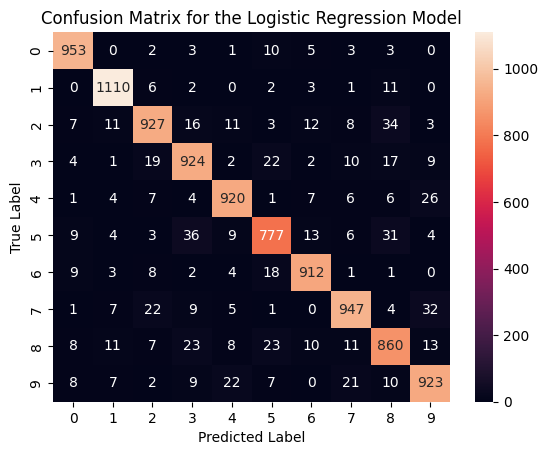

In [ ]:
cm = confusion_matrix(test_labels, lr_predictions)
sns.heatmap(cm, annot = True, fmt = "d")
plt.title("Confusion Matrix for the Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
#Random Forest Model Predictions
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 35)
rf_model.fit(train_features, train_labels)

rf_predictions = rf_model.predict(test_features)
rf_accuracy = accuracy_score(test_labels, rf_predictions)
rf_f1 = f1_score(test_labels, rf_predictions, average = "weighted")

In [ ]:
print('Accuracy:', rf_accuracy)
print('F1 score:', rf_f1)

Accuracy: 0.9695
F1 score: 0.9694775025842403


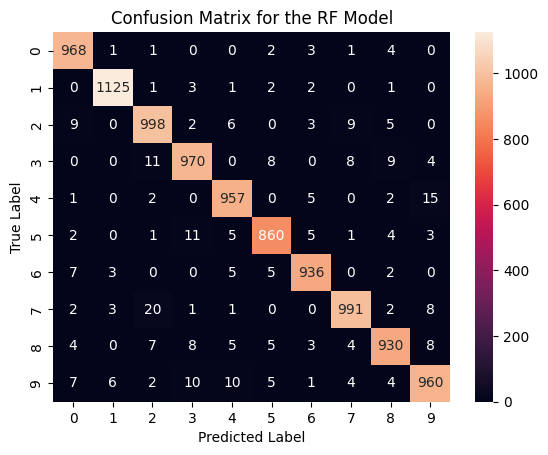

In [ ]:
cm = confusion_matrix(test_labels, rf_predictions)
sns.heatmap(cm, annot = True, fmt = "d")
plt.title("Confusion Matrix for the RF Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# t-SNE output from second layer
def get_activations(model, data_loader):
    activations = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            x = model.lin1(inputs.view(inputs.size(0), -1))
            output = model.lin2(x)
            activations.append(output)
            labels.append(lbls)
    activations = torch.cat(activations).cpu().numpy()
    labels = torch.cat(labels).numpy()
    return activations, labels

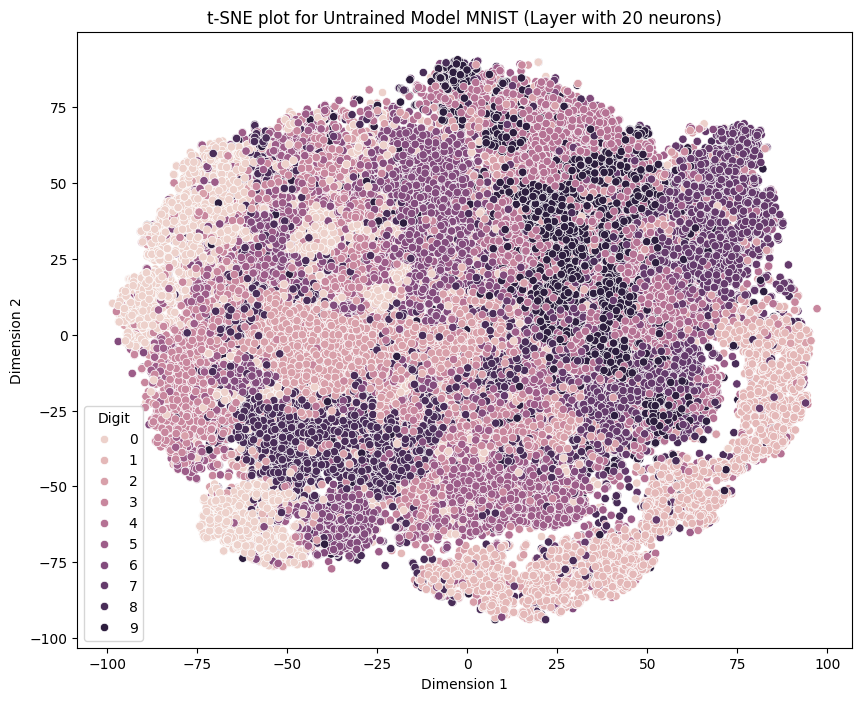

In [ ]:
# t-SNE plot for untrained model
train_activations, train_labels = get_activations(MLP().to(device), mnist_train_loader)
tsne = TSNE(n_components = 2, random_state = 35)
train_tsne = tsne.fit_transform(train_activations)
plt.figure(figsize = (10, 8))
sns.scatterplot(x = train_tsne[:, 0], y = train_tsne[:, 1], hue = train_labels, palette = "tab10", legend = "full")
plt.title("t-SNE plot for Untrained Model MNIST (Layer with 20 neurons)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = "Digit")
plt.show()

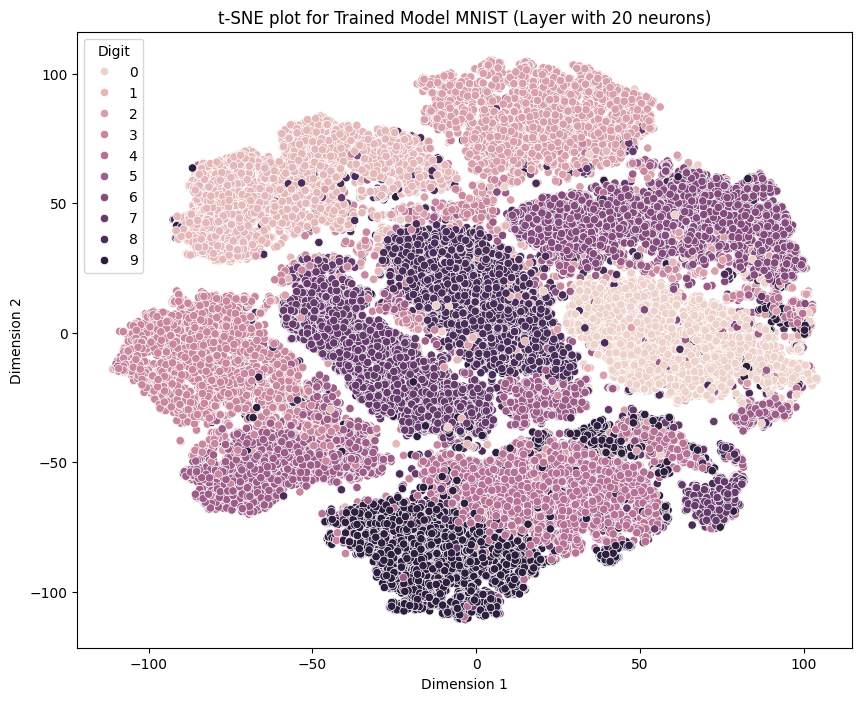

In [ ]:
# t-SNE plot for trained MLP
train_activations, train_labels = get_activations(model, mnist_train_loader)
tsne = TSNE(n_components = 2, random_state = 35)
train_tsne = tsne.fit_transform(train_activations)
plt.figure(figsize = (10, 8))
sns.scatterplot(x = train_tsne[:, 0], y = train_tsne[:, 1], hue = train_labels, palette = "tab10", legend = "full")
plt.title("t-SNE plot for Trained Model MNIST (Layer with 20 neurons)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = "Digit")
plt.show()

In [ ]:
# Fashion MNIST data load
fashion_train = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms)
fashion_test = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms)
fashion_combined = torch.utils.data.ConcatDataset([fashion_train, fashion_test])
fashion_loader = torch.utils.data.DataLoader(fashion_combined, batch_size = len(fashion_combined), shuffle = False)

100%|██████████| 26.4M/26.4M [00:08<00:00, 2.98MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.55MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.54MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



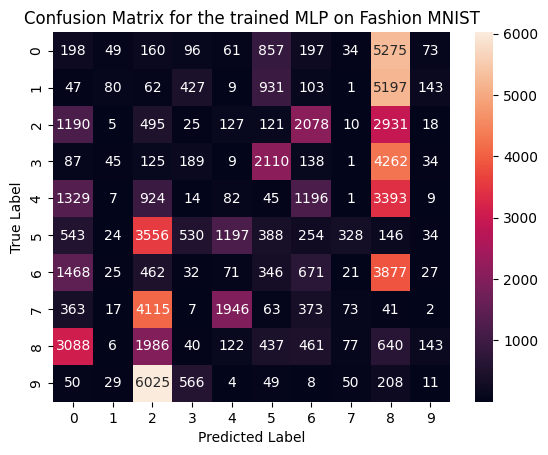

In [ ]:
# Confusion Matrix for the trained MLP on Fashion MNIST
test_predictions, test_ground_truth = predict(model, fashion_loader)
cm = confusion_matrix(test_ground_truth, test_predictions)
sns.heatmap(cm, annot = True, fmt = "d")
plt.title("Confusion Matrix for the trained MLP on Fashion MNIST")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Accuracy and F1score of MLP on Fashion MNIST
Fmodel_f1 = f1_score(test_ground_truth, test_predictions, average = "weighted")
Fmodel_accuracy = accuracy_score(test_ground_truth, test_predictions)
print('Accuracy:', Fmodel_accuracy)
print('F1 Score:', Fmodel_f1)

Accuracy: 0.04038571428571429
F1 Score: 0.037662477399951856


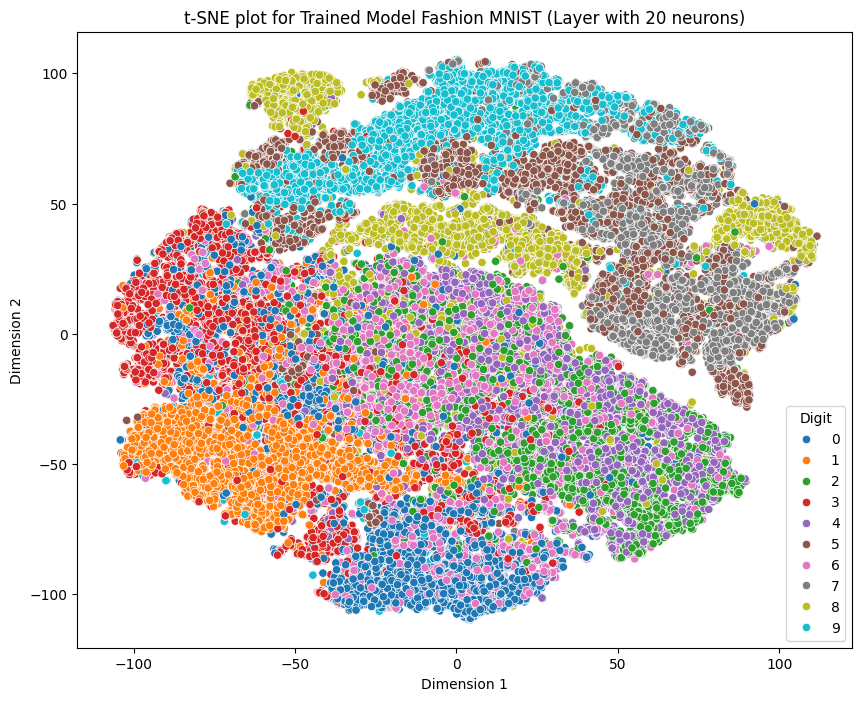

In [ ]:
# t-SNE plot of MLP on Fashion MNIST data set
activations, labels = get_activations(model, fashion_loader)
tsne = TSNE(n_components = 2, random_state = 35)
tsne = tsne.fit_transform(activations)
plt.figure(figsize = (10, 8))
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue = labels, palette = "tab10", legend = "full")
plt.title("t-SNE plot for Trained Model Fashion MNIST (Layer with 20 neurons)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title = "Digit")
plt.show()